In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 
import matplotlib as mpl
import seaborn
mpl.rcParams['figure.figsize']=(15.0,8.0)    
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
from matplotlib import pyplot as plt

import stingray as sr

from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum, Crossspectrum, AveragedCrossspectrum
from stingray import events
from stingray.events import EventList
import glob
import numpy as np
from astropy.modeling import models, fitting


# R.m.s. - intensity diagram

This diagram is used to characterize the variability of black hole binaries and AGN (see e.g. Plant et al., arXiv:1404.7498; McHardy 2010 2010LNP...794..203M for a review).

In Stingray it is very easy to calculate.

## Setup: simulate a light curve with a variable rms and rate
We simulate a light curve with powerlaw variability, and then we rescale
it so that it has increasing flux and r.m.s. variability.

In [3]:
from stingray.simulator.simulator import Simulator
from scipy.ndimage.filters import gaussian_filter1d
from stingray.utils import baseline_als
from scipy.interpolate import interp1d


np.random.seed(1034232)
# Simulate a light curve with increasing variability and flux
length = 10000
dt = 0.1
times = np.arange(0, length, dt)

# Create a light curve with powerlaw variability (index 1), 
# and smooth it to eliminate some Gaussian noise. We will simulate proper
# noise with the `np.random.poisson` function.
# Both should not be used together, because they alter the noise properties.
sim = Simulator(dt=dt, N=int(length/dt), mean=50, rms=0.4)
counts_cont = sim.simulate(1).counts
counts_cont_init = gaussian_filter1d(counts_cont, 200)

In [4]:
# ---------------------
# Renormalize so that the light curve has increasing flux and r.m.s. 
# variability.
# ---------------------


# The baseline function cannot be used with too large arrays. 
# Since it's just an approximation, we will just use one every
# ten array elements to calculate the baseline
mask = np.zeros_like(times, dtype=bool)
mask[::10] = True

baseline = baseline_als(counts_cont_init[mask], 1e10, 0.001)
base_func = interp1d(times[mask], baseline, bounds_error=False, fill_value='extrapolate')

counts_cont = counts_cont_init - base_func(times)

counts_cont -= np.min(counts_cont)
counts_cont += 1
counts_cont *= times * 0.003
# counts_cont += 500
counts_cont += 500


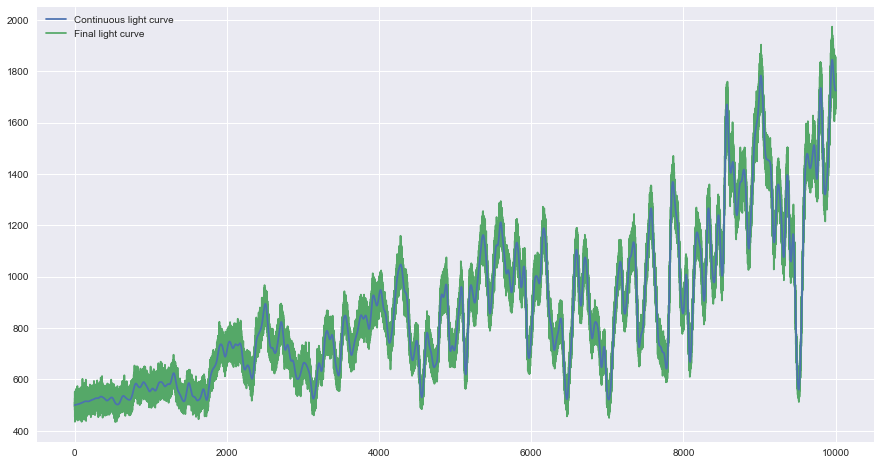

In [5]:
# Finally, Poissonize it!
counts = np.random.poisson(counts_cont)
plt.plot(times, counts_cont, zorder=10, label='Continuous light curve')
plt.plot(times, counts, label='Final light curve')

plt.legend()


## R.m.s. - intensity diagram

We use the `analyze_lc_chunks` method in `Lightcurve` to calculate two quantities: the rate and the excess variance, normalized as $F_{\rm var}$ (Vaughan et al. 2010).
`analyze_lc_chunks()` requires an input function that just accepts a light curve. Therefore, we create the two functions `rate` and `excvar` that wrap the existing functionality in Stingray.

Then, we plot the results.

Done!

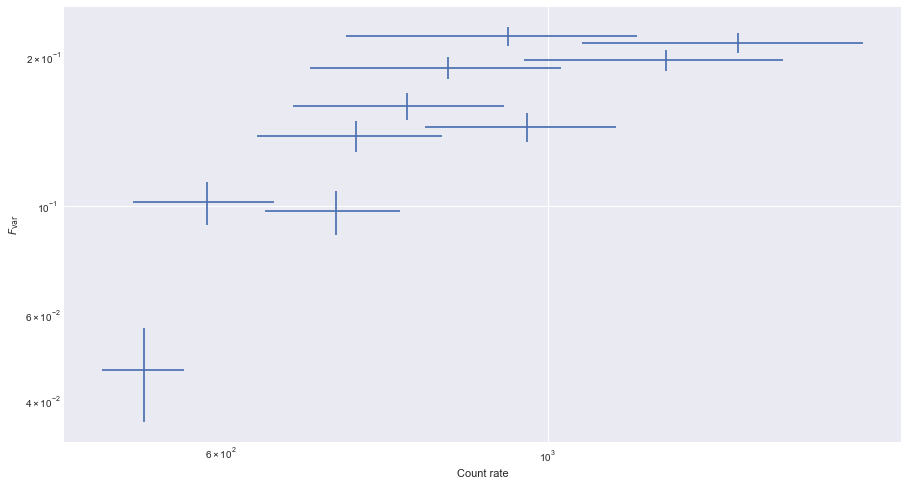

In [6]:
def excvar(lc):
    from stingray.utils import excess_variance
    return excess_variance(lc, normalization='fvar')

def rate(lc):
    return lc.meancounts, np.std(lc.counts)

lc = Lightcurve(times, counts, gti=[[-0.5*dt, length - 0.5*dt]], dt=dt)

start, stop, res = lc.analyze_lc_chunks(1000, rate)
rate, rate_err = res

start, stop, res = lc.analyze_lc_chunks(1000, excvar)
fvar, fvar_err = res

plt.errorbar(rate, fvar, xerr=rate_err, yerr=fvar_err, fmt='none')
plt.loglog()
plt.xlabel('Count rate')
plt.ylabel(r'$F_{\rm var}$')